# Business Problem
In the competitive grocery market, understanding vegetarian customer behavior is crucial for targeted promotions and product recommendations. We aim to leverage machine learning to predict whether a vegetarian user is ordering a specific food product for the first time (0) or re-ordering a familiar item (1). 
<p>This will enable us to:
<ul>
<li>Personalize recommendations: Recommend new and relevant food products to vegetarian users based on their past purchases (re-orders) and overall buying trends.</li>
<li>Optimize promotions: Design targeted promotions for first-time vegetarian purchases of specific products, potentially attracting new customers or encouraging them to try new items.</li>
<li>Improve customer experience: Enhance customer satisfaction by offering personalized recommendations and relevant promotions, leading to increased loyalty and repeat business.</li>
</ul>
By predicting re-orders vs. first-time purchases for vegetarian users, we can gain valuable insights into their buying habits and personalize our marketing strategies to drive sales and customer engagement.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from scipy.stats import uniform
from sklearn.metrics import accuracy_score,mean_squared_error,confusion_matrix,f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier,RandomForestRegressor, ExtraTreesClassifier,
                              BaggingClassifier, AdaBoostRegressor)

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, classification_report
import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split


#### Importing data
Source: https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis?resource=download

In [4]:
product_df=pd.read_csv('archive-3/products.csv')
aisles_df=pd.read_csv('archive-3/aisles.csv')
orders_df=pd.read_csv('archive-3/orders.csv')
dept_df=pd.read_csv('archive-3/departments.csv')
order_prod_train_df=pd.read_csv('archive-3/order_products__train.csv')
order_prod_df=pd.read_csv('archive-3/order_products__prior.csv')

### Check size of dataset

In [5]:
product_df.shape

(49688, 4)

In [6]:
aisles_df.shape

(134, 2)

In [7]:
orders_df.shape

(3421083, 7)

In [8]:
dept_df.shape

(21, 2)

In [9]:
order_prod_train_df.shape

(1384617, 4)

In [10]:
order_prod_df.shape

(32434489, 4)

In [11]:
orders_df.shape

(3421083, 7)

### EDA ON DATASET

In [12]:
product_df.head(10)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


In [13]:
aisles_df.head(10)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [14]:
orders_df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [15]:
dept_df.head(10)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [16]:
order_prod_train_df.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [17]:
order_prod_df.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


#### Merging datasets

<p> The merge() function is used repeatedly to merge these DataFrames together based on common columns. The on parameter specifies the column(s) on which to perform the merge. In this case, we are merging DataFrames on the following columns:
</p>
<ul>
    <li>product_df is merged with order_prod_df on the column product_id.</li>
    <li>orders_df is merged with the merged DataFrame from the previous step on the column order_id.</li>
    <li>dept_df is merged with the merged DataFrame from the previous step on the column department_id.</li>
    <li>aisles_df is merged with the merged DataFrame from the previous step on the column aisle_id.</li>
    
</ul>

The resulting DataFrame order_prod_merge_df will contain columns from all the merged DataFrames, with rows matched based on the specified common columns. e_id.

In [18]:
order_prod_merge_df= (order_prod_df.merge(product_df, on='product_id').merge(orders_df, on='order_id').merge(dept_df, on='department_id').merge(aisles_df, on='aisle_id'))

In [19]:
order_prod_merge_df.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,dairy eggs,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,dairy eggs,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,dairy eggs,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,dairy eggs,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,dairy eggs,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,dairy eggs,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,dairy eggs,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,dairy eggs,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,dairy eggs,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,dairy eggs,eggs


In [20]:
# Checkinf the last 10 records
order_prod_merge_df.tail(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
32434479,2637713,2216,1,0,California Champagne,134,5,161786,prior,14,6,3,20.0,alcohol,specialty wines champagnes
32434480,3091866,2216,1,1,California Champagne,134,5,161786,prior,22,5,13,2.0,alcohol,specialty wines champagnes
32434481,3134093,2216,1,1,California Champagne,134,5,161786,prior,21,3,15,3.0,alcohol,specialty wines champagnes
32434482,886132,12825,1,1,Sangria,134,5,137204,prior,13,6,8,13.0,alcohol,specialty wines champagnes
32434483,1894201,25992,1,0,Cristal Champagne,134,5,168275,prior,24,0,14,18.0,alcohol,specialty wines champagnes
32434484,3243156,20731,1,0,Straight Sherry,134,5,166400,prior,3,1,13,12.0,alcohol,specialty wines champagnes
32434485,860862,30582,1,0,Natural Champagne,134,5,104017,prior,13,5,14,18.0,alcohol,specialty wines champagnes
32434486,1333472,27906,1,0,Imperial Champagne,134,5,62079,prior,10,3,10,10.0,alcohol,specialty wines champagnes
32434487,2122701,26086,1,1,La Grand Dame Brut Champagne,134,5,77799,prior,2,3,14,3.0,alcohol,specialty wines champagnes
32434488,3168475,26086,1,1,La Grand Dame Brut Champagne,134,5,5223,prior,7,3,13,2.0,alcohol,specialty wines champagnes


In [21]:
# Getting the count of each product and sorting the count in descending order
product_value_counts= order_prod_merge_df['product_name'].value_counts().sort_values(ascending=False)

In [22]:
product_value_counts.head(10)

product_name
Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: count, dtype: int64

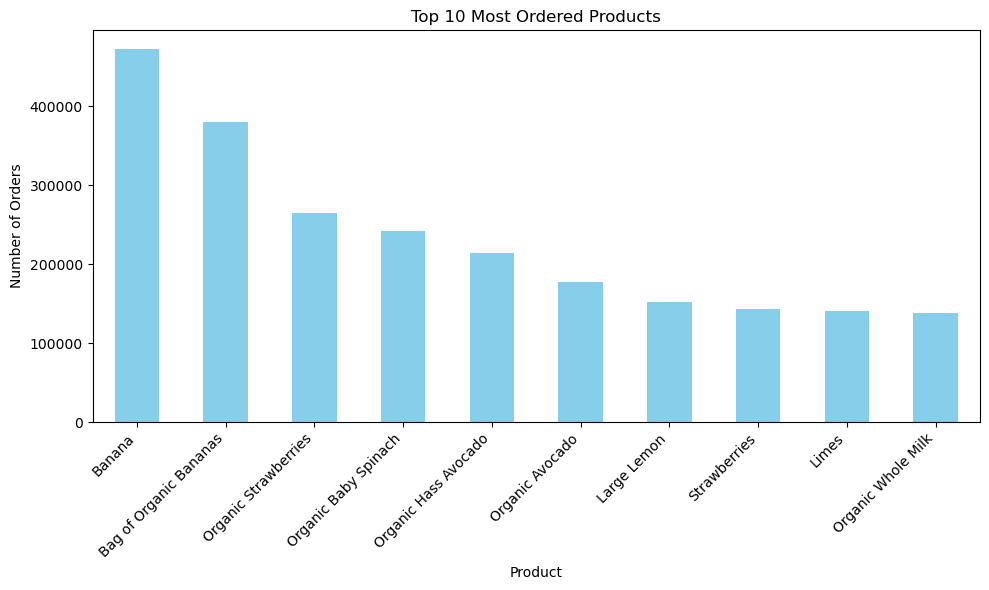

In [23]:
plt.figure(figsize=(10, 6))
product_value_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Ordered Products')
plt.xlabel('Product')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

As we can see, Banana is the most ordered product in our data, followed by Bag of Organic Bananas.

In [24]:
product_value_counts.tail(10)

product_name
Petite Black Eyed Peas             1
Organic Aleppo Pepper              1
Coconut Cardamom Almond Butter     1
Rosa Mosqueta Rose Hip Seed Oil    1
Cld/Flu Van Chrry                  1
Orange Recharge                    1
Miss Treated Conditioner           1
Dynostix Rawhide Chew With Meat    1
Cinnamon Rice Pudding Snacks       1
Hot Chili with Beans               1
Name: count, dtype: int64

In [25]:
dept_df

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [26]:
# Including only those items which are legit and non-alcololic
departments_included = [1, 3, 4, 6, 9, 10, 12, 13, 14, 15, 16, 18, 19]
food_related_orders_df = order_prod_merge_df[order_prod_merge_df['department_id'].isin(departments_included)].sort_values('order_id')

In [27]:
food_related_orders_df.shape

(27150466, 15)

In [28]:
# Aggregating data by order_id, to see which order_ids are the most occuring in our data
food_related_orders_df['order_id'].value_counts().sort_values(ascending=False).head()

order_id
1564244    115
1867980     96
1101266     94
2136777     94
598905      93
Name: count, dtype: int64

In [29]:
# Checking null values
food_related_orders_df.isnull().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    1733038
department                      0
aisle                           0
dtype: int64

In [30]:
# Checking the class of null values in "days_since_prior_order", which shows "0".
food_related_orders_df[food_related_orders_df['days_since_prior_order'].isnull()]['reordered'].value_counts()

reordered
0    1733038
Name: count, dtype: int64

In [31]:
# Filling null values with 0
food_related_orders_df.fillna(0, inplace = True)

In [32]:
food_related_orders_df.isnull().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
department_id             0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
department                0
aisle                     0
dtype: int64

In [33]:
# Checking datatype of each column
food_related_orders_df.dtypes

order_id                    int64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
product_name               object
aisle_id                    int64
department_id               int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
department                 object
aisle                      object
dtype: object

In [34]:
# Statistical Summary of data
food_related_orders_df.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,2.715047e+07,2.715047e+07,2.715047e+07,2.715047e+07,2.715047e+07,2.715047e+07,2.715047e+07,2.715047e+07,2.715047e+07,2.715047e+07,2.715047e+07
mean,1.710691e+06,2.570249e+04,8.479931e+00,5.930134e-01,7.104864e+01,9.628030e+00,1.029356e+05,1.721753e+01,2.726006e+00,1.343313e+01,1.036504e+01
std,9.873487e+05,1.406363e+04,7.126466e+00,4.912724e-01,3.874474e+01,6.351164e+00,5.945022e+04,1.757646e+01,2.097757e+00,4.255240e+00,8.886408e+00
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.556700e+05,1.370200e+04,3.000000e+00,0.000000e+00,2.400000e+01,4.000000e+00,5.142300e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710928e+06,2.519500e+04,7.000000e+00,1.000000e+00,8.300000e+01,9.000000e+00,1.025900e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565437e+06,3.820700e+04,1.200000e+01,1.000000e+00,1.070000e+02,1.600000e+01,1.543720e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.400000e+01
max,3.421083e+06,4.968600e+04,1.440000e+02,1.000000e+00,1.310000e+02,1.900000e+01,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01


In [35]:
# Counting each class in data
food_related_orders_df.groupby(by='reordered')['reordered'].count()

reordered
0    11049877
1    16100589
Name: reordered, dtype: int64

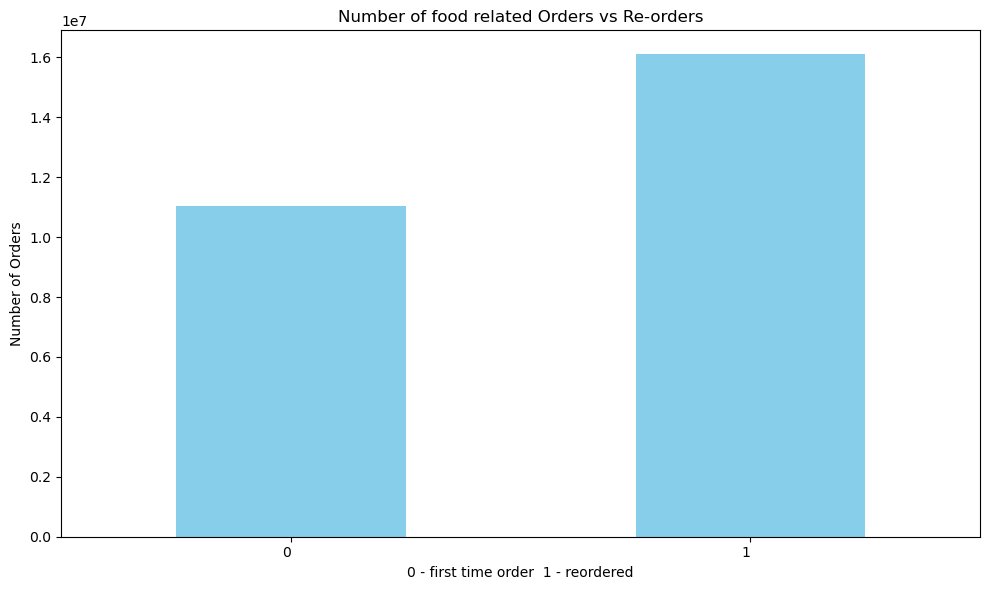

In [36]:
plt.figure(figsize=(10, 6))
food_related_orders_df.groupby(by='reordered')['reordered'].count().plot(kind='bar', color='skyblue')
plt.title('Number of food related Orders vs Re-orders')
plt.xlabel('0 - first time order  1 - reordered')
plt.ylabel('Number of Orders')
plt.xticks(rotation=None, ha='right')
plt.tight_layout()
plt.show()

As we can see, the number of re-orders are significantly more then first-time order.

In [37]:
# Mapping number to week day
days_of_the_week=['0=Sat', '1=Sun', '2=Mon', '3=Tue', '4=Wed', '5=Thu', '6=Fri']

In [38]:
# Getting number of orders with respect to each week day.
# As we can see, Saturday has the most number of orders, followed by Sunday, 
# Indicating that people are shopping more on weekends than normal week days
food_related_orders_df.groupby(by = 'order_dow')['order_dow'].count()

order_dow
0    5306512
1    4752453
2    3504733
3    3176333
4    3127569
5    3486065
6    3796801
Name: order_dow, dtype: int64

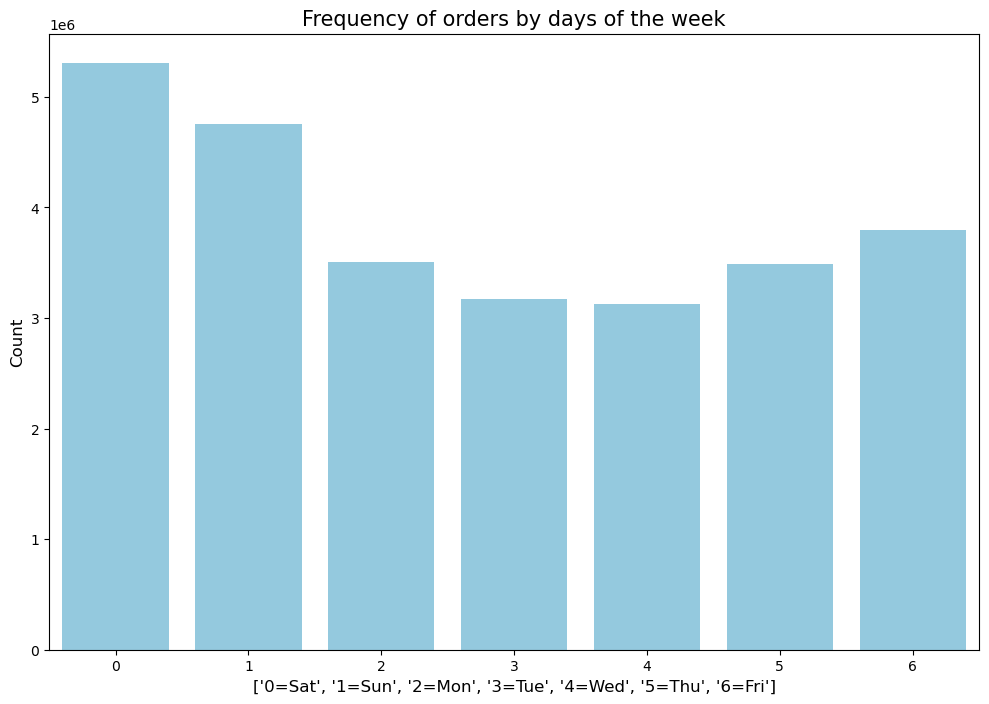

In [39]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_dow', data=food_related_orders_df,color='skyblue')
plt.ylabel('Count', fontsize=12)
plt.xlabel(days_of_the_week,fontsize=12)
plt.xticks(rotation='horizontal')
plt.title("Frequency of orders by days of the week", fontsize=15)
plt.show();

The graph suggests that most Instacart orders occur on weekends, particularly on Saturdays and Sundays, while the fewest orders are placed on Tuesdays and Wednesdays.

In [40]:
# Top 10 Pick for first time Order
food_related_orders_df[food_related_orders_df['reordered']==0]['product_name'].value_counts().sort_values(ascending=False).head(10)

product_name
Banana                    73956
Bag of Organic Bananas    63537
Organic Strawberries      58838
Organic Baby Spinach      55037
Large Lemon               46402
Limes                     44859
Organic Hass Avocado      43453
Strawberries              43149
Organic Avocado           42771
Organic Blueberries       37138
Name: count, dtype: int64

In [41]:
# Top 10 Pick for Re-Order
food_related_orders_df[food_related_orders_df['reordered']==1]['product_name'].value_counts().sort_values(ascending=False).head(10)

product_name
Banana                    398609
Bag of Organic Bananas    315913
Organic Strawberries      205845
Organic Baby Spinach      186884
Organic Hass Avocado      170131
Organic Avocado           134044
Organic Whole Milk        114510
Large Lemon               106255
Organic Raspberries       105409
Strawberries               99802
Name: count, dtype: int64

In [42]:
# Top 10 users who ordered the most
food_related_orders_df['user_id'].value_counts().sort_values(ascending=False).head(10)

user_id
201268    2893
33731     2679
182401    2597
164055    2569
108187    2465
129928    2263
60694     2262
176478    2261
13701     2169
79106     2148
Name: count, dtype: int64

In [43]:
# frequency of days since prior order
food_related_orders_df['days_since_prior_order'].value_counts().sort_index(ascending = True)

days_since_prior_order
0.0     2098399
1.0      768414
2.0     1216210
3.0     1575525
4.0     1752160
5.0     1795292
6.0     2133622
7.0     2943481
8.0     1632994
9.0     1023537
10.0     809022
11.0     685539
12.0     646318
13.0     712852
14.0     862826
15.0     562296
16.0     384649
17.0     317913
18.0     290357
19.0     278327
20.0     316406
21.0     370553
22.0     257304
23.0     187549
24.0     159836
25.0     149462
26.0     147548
27.0     169231
28.0     210969
29.0     145878
30.0    2545997
Name: count, dtype: int64

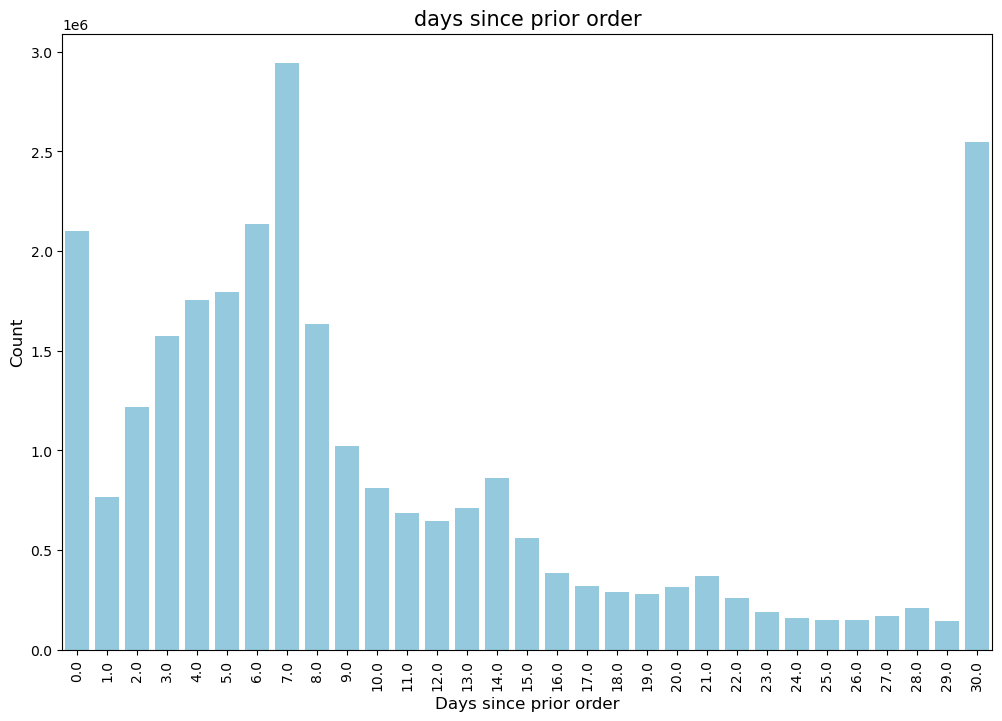

In [44]:
# Plotting distribution of days since prior order.
plt.figure(figsize = (12, 8))
sns.countplot(x="days_since_prior_order", data=food_related_orders_df, color = 'skyblue')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("days since prior order", fontsize=15)
plt.show();

The distribution shows that most of the days for prior order fall between 4 to 8 days.

### Separate out Vegetarian foods and Meat for further analysis

In [45]:
#  How many are Vegetarians
vegetarian_orders_df=food_related_orders_df[~((food_related_orders_df['product_name'].str.find('meat')>0)| 
                       (food_related_orders_df['department']=='meat seafood')|
                       (food_related_orders_df['aisle']== 'packaged meat')|
                       (food_related_orders_df['aisle']== 'packaged seafood')|
                       (food_related_orders_df['aisle']== 'frozen meat seafood')|
                       (food_related_orders_df['aisle']== 'seafood counter')|
                       (food_related_orders_df['aisle']== 'canned meat seafood')|
                       (food_related_orders_df['aisle']== 'lunch meat')|
                       (food_related_orders_df['aisle']== 'hot dogs bacon sausage')|
                       (food_related_orders_df['aisle']== 'meat counter'))
                      ]
                           
non_vegetarian_orders_df=food_related_orders_df[((food_related_orders_df['product_name'].str.find('meat')>0)| 
                       (food_related_orders_df['department']=='meat seafood')|
                       (food_related_orders_df['aisle']== 'packaged meat')|
                       (food_related_orders_df['aisle']== 'packaged seafood')|
                       (food_related_orders_df['aisle']== 'frozen meat seafood')|
                       (food_related_orders_df['aisle']== 'seafood counter')|
                       (food_related_orders_df['aisle']== 'canned meat seafood')|
                       (food_related_orders_df['aisle']== 'lunch meat')|
                       (food_related_orders_df['aisle']== 'hot dogs bacon sausage')|
                       (food_related_orders_df['aisle']== 'meat counter'))
                      ]    

In [46]:
print('shape of vegetarian_orders_df = ',vegetarian_orders_df.shape)
print('shape of non_vegetarian_orders_df = ',non_vegetarian_orders_df.shape)
print('Total = ',(vegetarian_orders_df.shape[0]+non_vegetarian_orders_df.shape[0]))

shape of vegetarian_orders_df =  (26297625, 15)
shape of non_vegetarian_orders_df =  (852841, 15)
Total =  27150466


#### find the number of users who ordered only veg food

In [47]:
veg_id = set(vegetarian_orders_df['user_id'])
non_veg_id = set(non_vegetarian_orders_df['user_id'])

# Set of users who ordered both vegetarian food and meat food
veg_non_veg_users=veg_id.intersection(non_veg_id)


# Set of users who ordered only vegetarian food and no meat food
only_veggie_users = veg_id-non_veg_id

In [48]:
# All the unique users - List of Veg and Non Veg users
len(set(vegetarian_orders_df['user_id']))


205096

In [49]:
len(only_veggie_users)

79352

In [50]:
non_veg_id = set(non_vegetarian_orders_df['user_id'])
veg_id = set(vegetarian_orders_df['user_id'])

# Set of users who ordered both vegetarian food and non-vegetarian food
veg_non_veg_users = veg_id.intersection(non_veg_id)

# Set of users who ordered only non-vegetarian food and no vegetarian food
only_non_veggie_users = non_veg_id - veg_id


In [51]:
len(only_non_veggie_users)

63

In [52]:
# Validate Orders related to Meat - By a specific user
non_vegetarian_orders_df[non_vegetarian_orders_df['user_id']==10]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
17019850,68288,9339,10,0,Organic Chicken & Apple Sausage,106,12,10,prior,2,5,15,30.0,meat seafood,hot dogs bacon sausage
17019851,68288,28986,12,0,Mild Italian Chicken Sausage,106,12,10,prior,2,5,15,30.0,meat seafood,hot dogs bacon sausage
17019849,68288,5646,11,0,Organic Turkey Bacon,106,12,10,prior,2,5,15,30.0,meat seafood,hot dogs bacon sausage
17388843,68288,13198,9,0,85% Lean Ground Beef,122,12,10,prior,2,5,15,30.0,meat seafood,meat counter
17467112,68288,47380,2,0,New York Style Nova Lox,15,12,10,prior,2,5,15,30.0,meat seafood,packaged seafood
17266128,83395,38293,6,0,Ground Turkey Breast,35,12,10,prior,4,3,15,14.0,meat seafood,poultry counter
17022307,83395,9339,5,1,Organic Chicken & Apple Sausage,106,12,10,prior,4,3,15,14.0,meat seafood,hot dogs bacon sausage
17389775,83395,9871,8,0,Beef Loin New York Strip Steak,122,12,10,prior,4,3,15,14.0,meat seafood,meat counter
17022308,83395,17828,7,0,Organic Spinach & Feta Dinner Sausage,106,12,10,prior,4,3,15,14.0,meat seafood,hot dogs bacon sausage
17023343,1353310,17828,6,1,Organic Spinach & Feta Dinner Sausage,106,12,10,prior,5,5,20,23.0,meat seafood,hot dogs bacon sausage


In [53]:
vegetarian_orders_df[vegetarian_orders_df['user_id']==10]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
14993178,68288,7746,40,0,Oregano,104,13,10,prior,2,5,15,30.0,pantry,spices seasonings
14993180,68288,8988,38,0,Organic Garlic Powder,104,13,10,prior,2,5,15,30.0,pantry,spices seasonings
14993179,68288,35725,42,0,Organic Oregano,104,13,10,prior,2,5,15,30.0,pantry,spices seasonings
7378778,68288,15937,23,0,Shallot,83,4,10,prior,2,5,15,30.0,produce,fresh vegetables
7378777,68288,5818,25,0,White Onion,83,4,10,prior,2,5,15,30.0,produce,fresh vegetables
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5867481,2115522,17794,7,0,Carrots,83,4,10,prior,3,3,19,12.0,produce,fresh vegetables
5054111,2115522,42736,32,0,Unsalted Butter,36,16,10,prior,3,3,19,12.0,dairy eggs,butter
8959189,2115522,4920,20,0,Seedless Red Grapes,123,4,10,prior,3,3,19,12.0,produce,packaged vegetables fruits
10857393,2115522,16797,19,1,Strawberries,24,4,10,prior,3,3,19,12.0,produce,fresh fruits


In [54]:
vegetarian_orders_df[vegetarian_orders_df['user_id']==3]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
9091960,444309,21903,2,1,Organic Baby Spinach,123,4,3,prior,2,3,19,9.0,produce,packaged vegetables fruits
577666,444309,17668,6,1,Unsweetened Chocolate Almond Breeze Almond Milk,91,16,3,prior,2,3,19,9.0,dairy eggs,soy lactosefree
22448700,444309,32402,9,1,"Crackers, Crispy, Cheddar",78,19,3,prior,2,3,19,9.0,snacks,crackers
2100831,444309,38596,1,0,Part Skim Ricotta Cheese,108,16,3,prior,2,3,19,9.0,dairy eggs,other creams cheeses
11090123,444309,21137,7,0,Organic Strawberries,24,4,3,prior,2,3,19,9.0,produce,fresh fruits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627124,3225766,39190,1,1,Vanilla Unsweetened Almond Milk,91,16,3,prior,8,0,17,7.0,dairy eggs,soy lactosefree
1271831,3225766,22035,2,1,Organic Whole String Cheese,21,16,3,prior,8,0,17,7.0,dairy eggs,packaged cheese
27443218,3225766,18599,4,1,Garlic Couscous,4,9,3,prior,8,0,17,7.0,dry goods pasta,instant foods
9382013,3225766,21903,5,1,Organic Baby Spinach,123,4,3,prior,8,0,17,7.0,produce,packaged vegetables fruits


In [55]:
non_vegetarian_orders_df[non_vegetarian_orders_df['user_id']==3]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle


In [56]:
# Orders from users who we identified as Vegetarian users
# Orders from only_veggie_users
only_vegetarian_df=vegetarian_orders_df[vegetarian_orders_df['user_id'].isin(only_veggie_users)]
only_vegetarian_df

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
25935941,4,21351,6,1,Nutri-Grain Soft Baked Strawberry Cereal Break...,48,14,178520,prior,36,1,9,7.0,breakfast,breakfast bars pastries
22482283,4,17616,10,1,Goldfish Cheddar Baked Snack Crackers,78,19,178520,prior,36,1,9,7.0,snacks,crackers
23128877,4,39758,3,1,Chewy 25% Low Sugar Chocolate Chip Granola,3,19,178520,prior,36,1,9,7.0,snacks,energy granola bars
24083338,4,34862,8,1,Tiny Twists Pretzels,107,19,178520,prior,36,1,9,7.0,snacks,chips pretzels
31364969,4,46842,1,0,Plain Pre-Sliced Bagels,93,3,178520,prior,36,1,9,7.0,bakery,breakfast bakery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23841337,3421083,7854,1,0,Freeze Dried Mango Slices,117,19,25247,prior,24,2,6,21.0,snacks,nuts seeds dried fruit
18994659,3421083,4600,8,0,All Natural French Toast Sticks,52,1,25247,prior,24,2,6,21.0,frozen,frozen breakfast
32106054,3421083,35211,5,0,Organic Strawberry & Mango Dried Tiny Fruits,92,18,25247,prior,24,2,6,21.0,babies,baby food formula
32106051,3421083,21162,3,0,Organic Mixed Berry Yogurt & Fruit Snack,92,18,25247,prior,24,2,6,21.0,babies,baby food formula


In [57]:
only_vegetarian_df['product_name'].nunique()

27260

In [58]:
only_vegetarian_df['product_name'].value_counts().sort_values(ascending=False).head(20)

product_name
Banana                    107350
Bag of Organic Bananas     96137
Organic Strawberries       48070
Organic Baby Spinach       47362
Organic Hass Avocado       42442
Strawberries               33272
Organic Avocado            29762
Organic Raspberries        27961
Large Lemon                26765
Organic Fuji Apple         26148
Organic Half & Half        26101
Organic Whole Milk         25405
Organic Blueberries        24304
Limes                      23124
Half & Half                22147
Raspberries                19155
Clementines                18886
Organic Lemon              18653
Seedless Red Grapes        17921
Organic Baby Carrots       17564
Name: count, dtype: int64

<Axes: xlabel='product_name'>

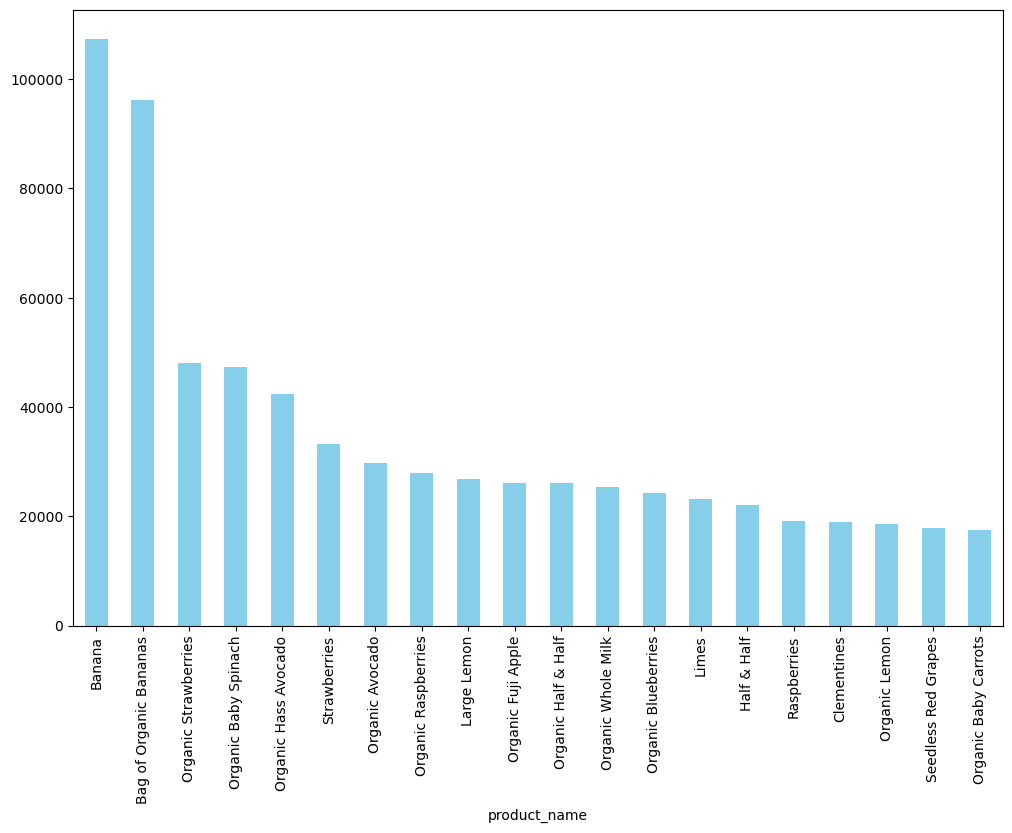

In [59]:
only_vegetarian_df['product_name'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar', figsize=(12,8), color='skyblue')

### Top 20 products Vegetarian users ordered in their weekly reorders

In [60]:
only_vegetarian_df[only_vegetarian_df['days_since_prior_order']==7]['product_name'].value_counts().sort_values(ascending=False).head(20)

product_name
Banana                                  15258
Bag of Organic Bananas                  11823
Organic Strawberries                     5321
Organic Baby Spinach                     4615
Organic Hass Avocado                     4613
Organic Fuji Apple                       4563
Organic Half & Half                      4172
Strawberries                             4064
Half & Half                              3740
Clementines                              3257
Organic Raspberries                      3226
Large Lemon                              3035
Organic Avocado                          2997
Organic Whole Milk                       2958
Organic Blueberries                      2626
Organic Gala Apples                      2600
Organic Large Extra Fancy Fuji Apple     2484
Seedless Red Grapes                      2480
Honeycrisp Apple                         2416
Apple Honeycrisp Organic                 2408
Name: count, dtype: int64

<Axes: ylabel='product_name'>

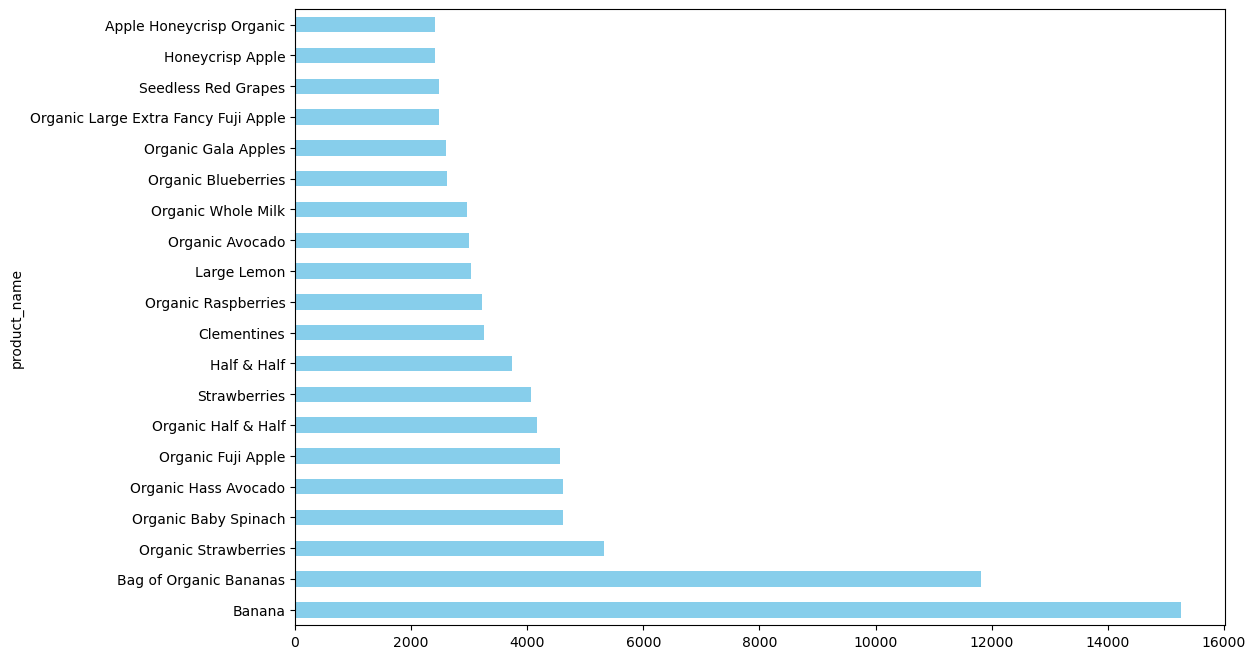

In [61]:
only_vegetarian_df[only_vegetarian_df['days_since_prior_order']==7]['product_name'].value_counts(ascending=False).head(20).plot(kind='barh', figsize=(12,8), color = 'skyblue')

### Top 20 products which were added to users shopping cart first (first item added to the cart) in their re-orders

<Axes: ylabel='product_name'>

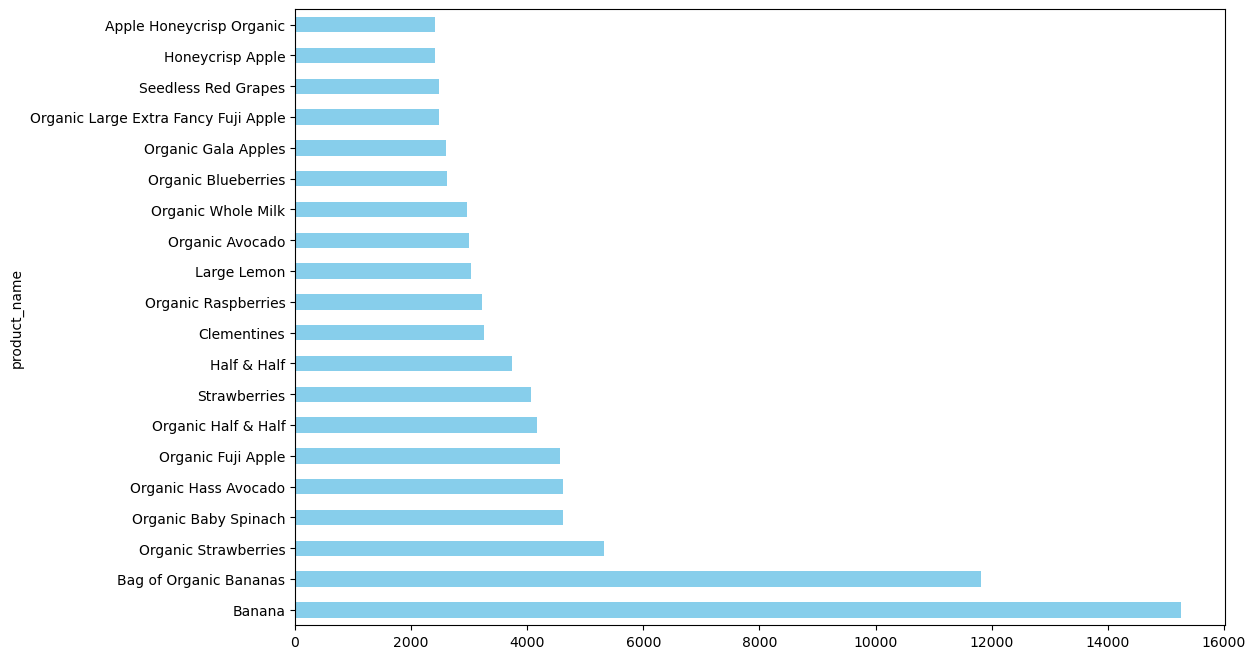

In [62]:
only_vegetarian_df[only_vegetarian_df['days_since_prior_order']==7]['product_name'].value_counts(ascending=False).head(20).plot(kind='barh', figsize=(12,8), color = 'skyblue')

In [63]:
non_numeric_columns = ['product_name', 'department', 'aisle', 'eval_set']


only_vegetarian_df = only_vegetarian_df.drop(columns=non_numeric_columns)

In [64]:
only_vegetarian_df.head()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
25935941,4,21351,6,1,48,14,178520,36,1,9,7.0
22482283,4,17616,10,1,78,19,178520,36,1,9,7.0
23128877,4,39758,3,1,3,19,178520,36,1,9,7.0
24083338,4,34862,8,1,107,19,178520,36,1,9,7.0
31364969,4,46842,1,0,93,3,178520,36,1,9,7.0


In [65]:
# Dropping null values
only_vegetarian_df = only_vegetarian_df.dropna()

### Model Development

In [66]:
only_vegetarian_df.shape

(5647220, 11)

In [67]:
# Separating independent and dependent features
X = only_vegetarian_df.drop('reordered', axis=1)
y = only_vegetarian_df['reordered']

In [68]:
y.value_counts(normalize=True)

reordered
1    0.575909
0    0.424091
Name: proportion, dtype: float64

In [69]:
# Splitting the data into training and testing, with a split raito of 70:30
# Using stratify=y to put equal proportions of each class in all the subsets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

In [70]:
model = LogisticRegression()


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print("accuracy:", accuracy_score(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
print("tn, fp, fn, tp:", tn, fp, fn, tp)
print(classification_report(y_test, y_pred))

[[     0 718480]
 [     0 975686]]
accuracy: 0.5759093264768623
tn, fp, fn, tp: 0 718480 0 975686
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    718480
           1       0.58      1.00      0.73    975686

    accuracy                           0.58   1694166
   macro avg       0.29      0.50      0.37   1694166
weighted avg       0.33      0.58      0.42   1694166



In [71]:
print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 0.5759094107998525
test score: 0.5759093264768623


In [72]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


ros = RandomOverSampler(random_state=42)


X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


print("New class distribution:", y_train_resampled.value_counts())

New class distribution: reordered
0    2276601
1    2276601
Name: count, dtype: int64


In [73]:
model = LogisticRegression()


model.fit(X_train_resampled, y_train_resampled)


y_pred = model.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Confusion Matrix:
 [[572630 145850]
 [427688 547998]]
Accuracy: 0.6614629263012007
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.80      0.67    718480
           1       0.79      0.56      0.66    975686

    accuracy                           0.66   1694166
   macro avg       0.68      0.68      0.66   1694166
weighted avg       0.70      0.66      0.66   1694166



In [74]:
print("train score:", model.score(X_train_resampled, y_train_resampled))
print("test score:", model.score(X_test, y_test))

train score: 0.6783500929675425
test score: 0.6614629263012007


In [98]:
# Decision Tree Classifier
tree = DecisionTreeClassifier(max_depth=5) 
tree.fit(X_train, y_train)                 
print("train score:", tree.score(X_train, y_train))
print("test score:", tree.score(X_test, y_test))

train score: 0.7285949040918743
test score: 0.7287196177942421


In [76]:
y_pred_tree = tree.predict(X_test)
print(confusion_matrix(y_test, y_pred_tree))
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_tree).ravel()
print("tn, fp, fn, tp:", tn, fp, fn, tp)
print("accuracy:", accuracy_score(y_test, y_pred_tree))
print("f1 score:",f1_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

[[421479 297001]
 [162593 813093]]
tn, fp, fn, tp: 421479 297001 162593 813093
accuracy: 0.7287196177942421
f1 score: 0.779653654747864
              precision    recall  f1-score   support

           0       0.72      0.59      0.65    718480
           1       0.73      0.83      0.78    975686

    accuracy                           0.73   1694166
   macro avg       0.73      0.71      0.71   1694166
weighted avg       0.73      0.73      0.72   1694166



In [77]:


xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  
    n_estimators=100,  
    learning_rate=0.1,  
    max_depth=3,  
    use_label_encoder=False,  
    eval_metric='logloss',  
    seed=42 
)


xgb_classifier.fit(X_train, y_train)


y_pred = xgb_classifier.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Confusion Matrix:
 [[423830 294650]
 [138927 836759]]
Accuracy: 0.7440764364294881
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.59      0.66    718480
           1       0.74      0.86      0.79    975686

    accuracy                           0.74   1694166
   macro avg       0.75      0.72      0.73   1694166
weighted avg       0.75      0.74      0.74   1694166



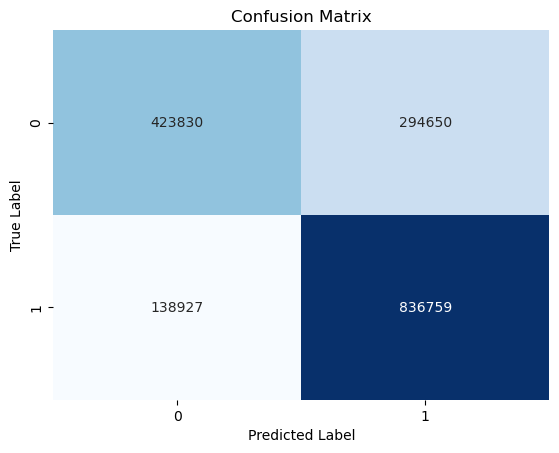

In [78]:
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(facecolor='white')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [79]:
print("train score:", xgb_classifier.score(X_train, y_train))
print("test score:", xgb_classifier.score(X_test, y_test))

train score: 0.7438732180233308
test score: 0.7440764364294881


In [80]:
y_scores = xgb_classifier.predict_proba(X_test)[:, 1]

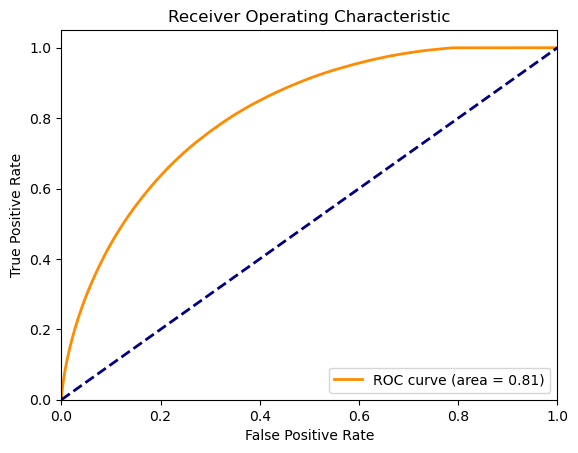

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)


plt.figure(facecolor='white')
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Pipeline

In [82]:
def model_evaluation(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred_test))

    # train and test scores
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    print("Train score:", train_acc)
    print("Test score:", test_acc)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)

    # Plotting the confusion matrix
    plt.figure(facecolor='white')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # If model has predict_proba method, plot ROC Curve
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(facecolor='white')
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    return train_acc, test_acc

#### Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    718480
           1       0.58      1.00      0.73    975686

    accuracy                           0.58   1694166
   macro avg       0.29      0.50      0.37   1694166
weighted avg       0.33      0.58      0.42   1694166

Train score: 0.5759094107998525
Test score: 0.5759093264768623


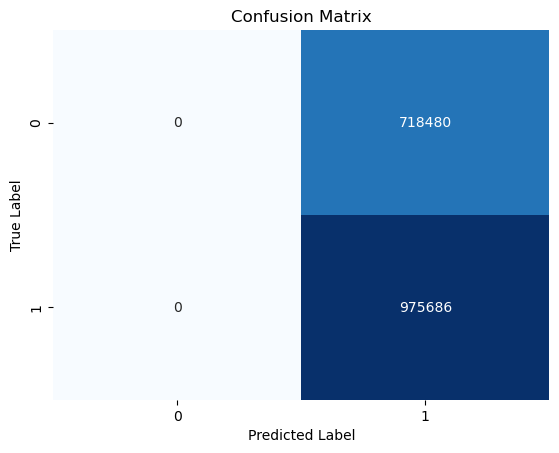

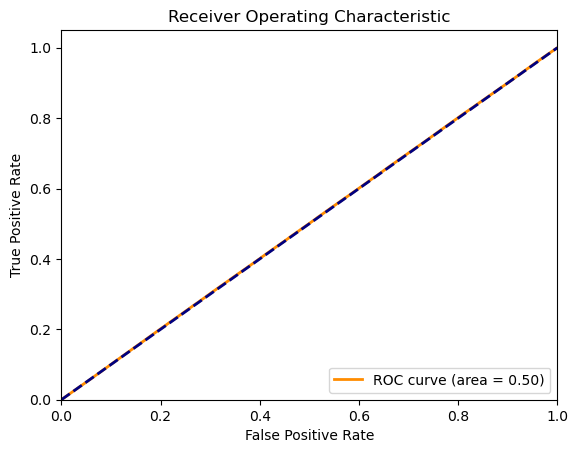

In [83]:
lr = LogisticRegression()

lr_train_acc, lr_test_acc = model_evaluation(lr, X_train, X_test, y_train, y_test)

The metrics indicate that logistic regression failed to perform well. The ROC-AUC curve shows that model is close to a random model.

#### Decision Tree Classifier

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.59      0.65    718480
           1       0.73      0.83      0.78    975686

    accuracy                           0.73   1694166
   macro avg       0.73      0.71      0.71   1694166
weighted avg       0.73      0.73      0.72   1694166

Train score: 0.7285949040918743
Test score: 0.7287196177942421


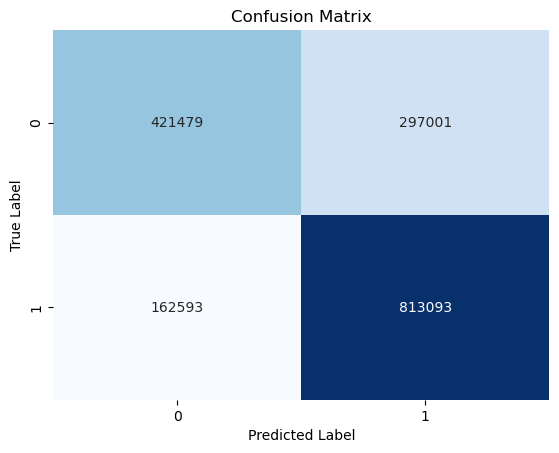

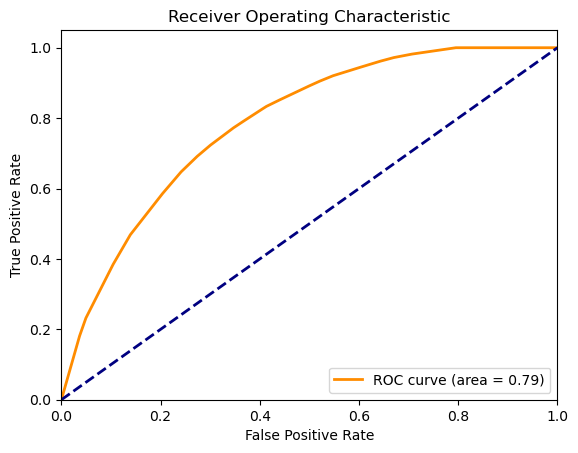

In [84]:
dt = DecisionTreeClassifier(max_depth=5)

dt_train_acc, dt_test_acc = model_evaluation(dt, X_train, X_test, y_train, y_test)

The model is currently giving an accuracy of around 73%, indicating fairly well performance as respect to Logistic Regression. This is mainly due to the fact that tree-based models can capture non-linear relationships in the data, whereas logistic regression is a linear model.

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.59      0.66    718480
           1       0.74      0.86      0.79    975686

    accuracy                           0.74   1694166
   macro avg       0.75      0.72      0.73   1694166
weighted avg       0.75      0.74      0.74   1694166

Train score: 0.7438732180233308
Test score: 0.7440764364294881


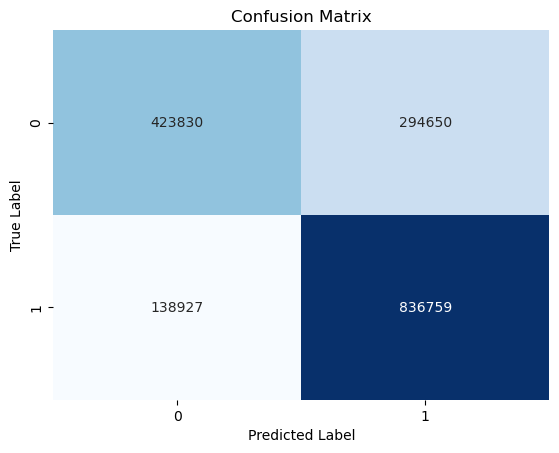

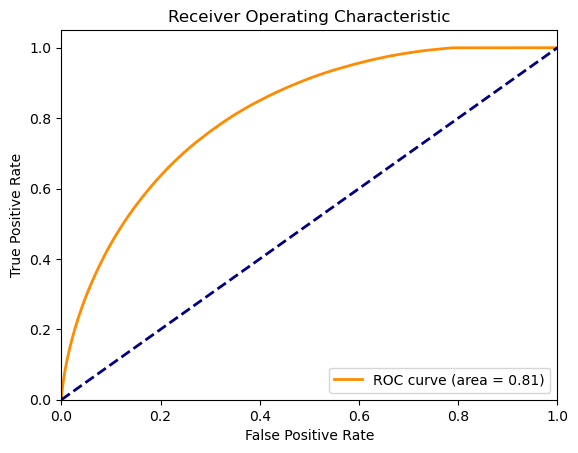

In [85]:
xgb = XGBClassifier(
    objective='binary:logistic',  
    n_estimators=100,  
    learning_rate=0.1,  
    max_depth=3,  
    use_label_encoder=False,  
    eval_metric='logloss',  
    seed=42 
)

xgb_train_acc, xgb_test_acc = model_evaluation(xgb, X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.00      0.00    718480
           1       0.58      1.00      0.73    975686

    accuracy                           0.58   1694166
   macro avg       0.66      0.50      0.37   1694166
weighted avg       0.65      0.58      0.42   1694166

Train score: 0.5759139642413182
Test score: 0.5759128680424468


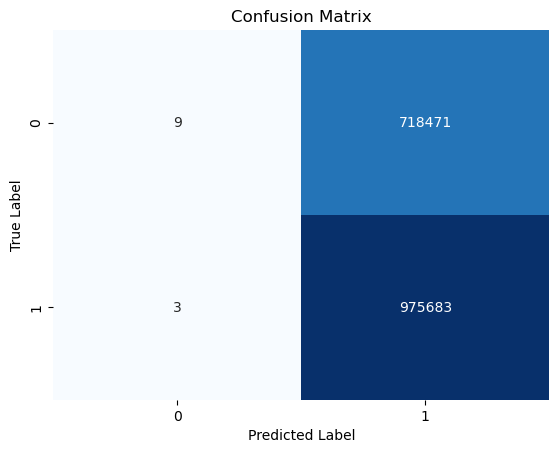

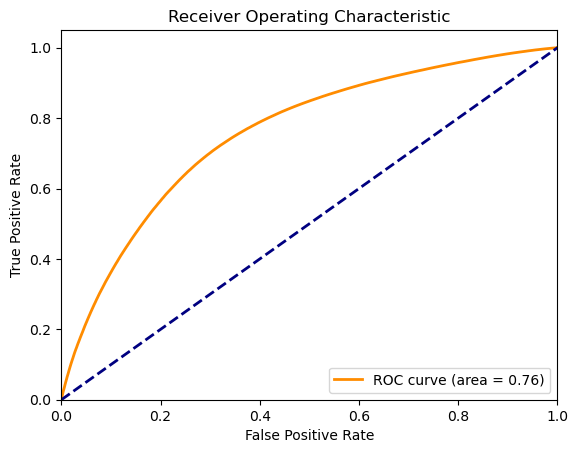

In [86]:
nb = GaussianNB()

nb_train_acc, nb_test_acc = model_evaluation(nb, X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.63      0.69    718480
           1       0.76      0.85      0.80    975686

    accuracy                           0.76   1694166
   macro avg       0.76      0.74      0.74   1694166
weighted avg       0.76      0.76      0.75   1694166

Train score: 0.9999959524964749
Test score: 0.7558474199104456


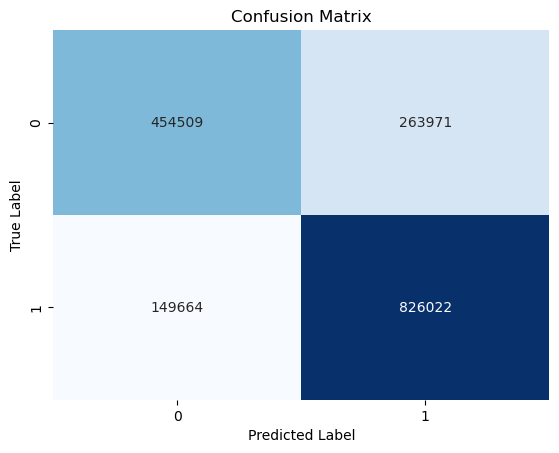

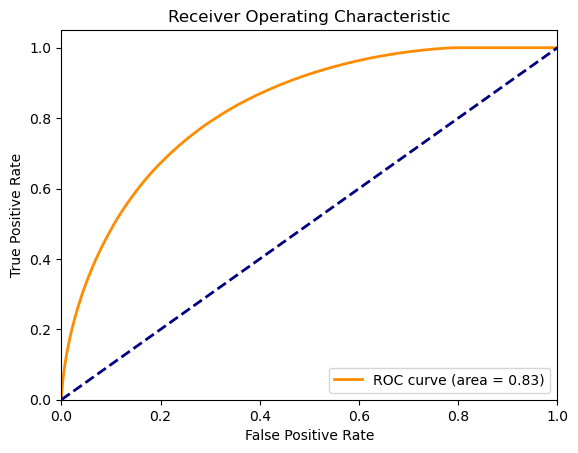

In [87]:
rfc = RandomForestClassifier(n_jobs=-1)

rfc_train_acc, rfc_test_acc = model_evaluation(rfc, X_train, X_test, y_train, y_test)

#### Voting Classifier

In [88]:
# Base classifiers
# rf_clf = RandomForestClassifier()
xgb_clf = XGBClassifier()
dt_clf = DecisionTreeClassifier()
nb_clf = GaussianNB()
lr_clf = LogisticRegression()

# Voting classifier
voting_clf = VotingClassifier(estimators=[
    # ('rf', rf_clf),
    ('xgb', xgb_clf),
    ('dt', dt_clf),
    ('nb', nb_clf),
    ('lr', lr_clf)
], voting='hard')

# Stacking
stacking_clf = StackingClassifier(estimators=[
    # ('rf', rf_clf),
    ('xgb', xgb_clf),
    ('dt', dt_clf),
    ('nb', nb_clf),
    ('lr', lr_clf)
], final_estimator=XGBClassifier())

# # Training the models
# voting_clf.fit(X_train, y_train)
# stacking_clf.fit(X_train, y_train)

# # Making predictions
# voting_pred = voting_clf.predict(X_test)
# stacking_pred = stacking_clf.predict(X_test)

# # Evaluating performance
# voting_accuracy = accuracy_score(y_test, voting_pred)
# stacking_accuracy = accuracy_score(y_test, stacking_pred)

# print("Voting Classifier Accuracy:", voting_accuracy)
# print("Stacking Classifier Accuracy:", stacking_accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.48      0.60    718480
           1       0.71      0.91      0.80    975686

    accuracy                           0.73   1694166
   macro avg       0.76      0.70      0.70   1694166
weighted avg       0.75      0.73      0.71   1694166

Train score: 0.8361934848347632
Test score: 0.7312500664043547


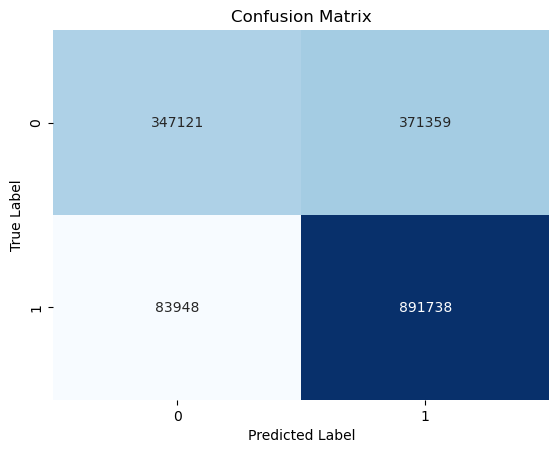

In [89]:
voting_train_acc, voting_test_acc = model_evaluation(voting_clf, X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68    718480
           1       0.75      0.85      0.80    975686

    accuracy                           0.75   1694166
   macro avg       0.75      0.73      0.74   1694166
weighted avg       0.75      0.75      0.75   1694166

Train score: 0.7719838889122183
Test score: 0.7513998037972667


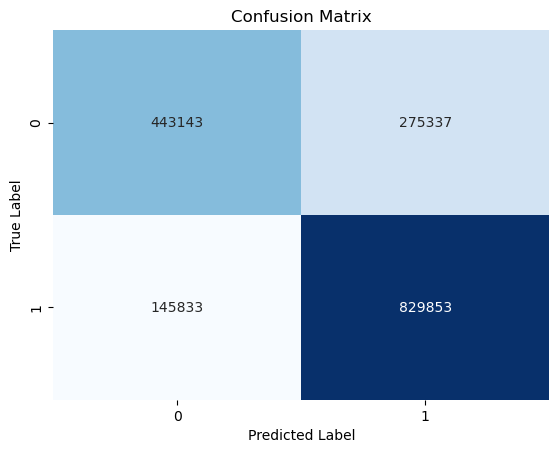

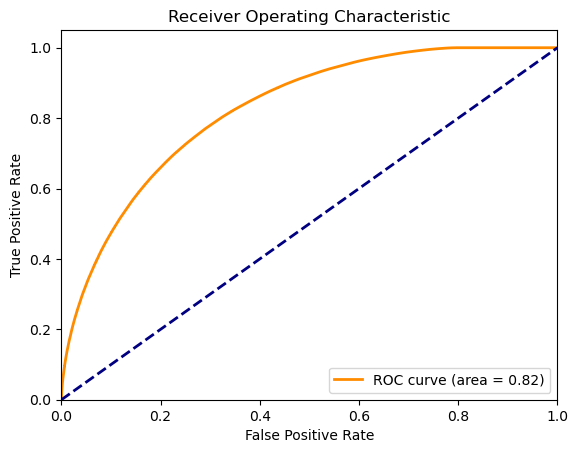

In [90]:
stacking_train_acc, stacking_test_acc = model_evaluation(stacking_clf, X_train, X_test, y_train, y_test)

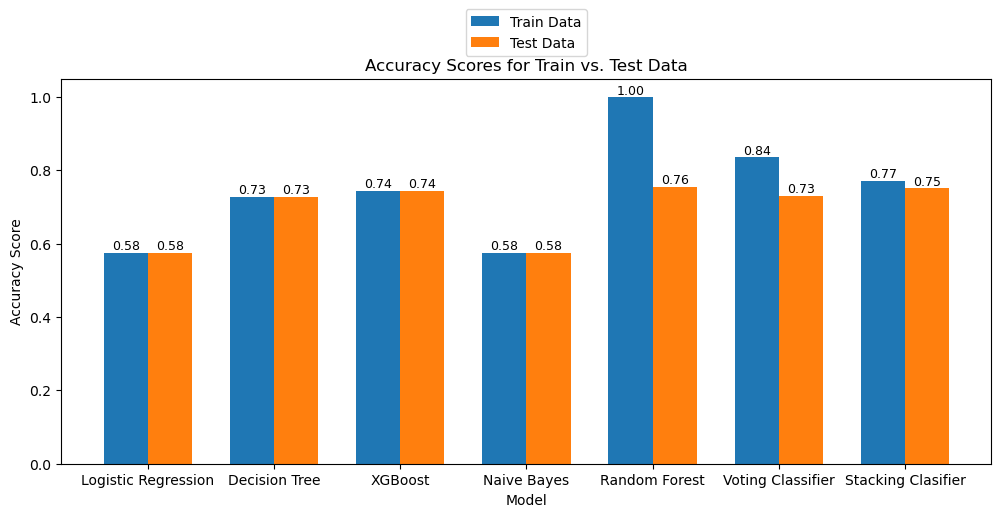

In [91]:
models = ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Naive Bayes', 'Random Forest', 'Voting Classifier', 'Stacking Clasifier']
train_accuracies = [lr_train_acc, dt_train_acc, xgb_train_acc, nb_train_acc, rfc_train_acc, voting_train_acc, stacking_train_acc]
test_accuracies = [lr_test_acc, dt_test_acc, xgb_test_acc, nb_test_acc, rfc_test_acc, voting_test_acc, stacking_test_acc]

bar_width = 0.35
train_pos = np.arange(len(models))
test_pos = train_pos + bar_width

fig, ax = plt.subplots(figsize=(12,5))
plt.title('Accuracy Scores for Train vs. Test Data')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')

train_bars = ax.bar(train_pos, train_accuracies, width=bar_width, label='Train Data')
test_bars = ax.bar(test_pos, test_accuracies, width=bar_width, label='Test Data')

# Add annotations on top of each bar
for train_bar, test_bar, train_score, test_score in zip(train_bars, test_bars, train_accuracies, test_accuracies):
    ax.text(train_bar.get_x() + train_bar.get_width() / 2, train_bar.get_height(),
            f'{train_score:.2f}', ha='center', va='bottom', fontsize=9, color='black')
    ax.text(test_bar.get_x() + test_bar.get_width() / 2, test_bar.get_height(),
            f'{test_score:.2f}', ha='center', va='bottom', fontsize=9, color='black')

tick_pos = np.arange(len(models))
ax.set_xticks(tick_pos + bar_width / 2)
ax.set_xticklabels(models)

plt.legend(loc='center', bbox_to_anchor=(0.5, 1.12))

plt.show()


### Hyperparameter tuning of XGBoost

In [92]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 10],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'n_estimators': [200, 400, 500, 1000],
}

xgb = XGBClassifier()

xgb_tune = RandomizedSearchCV(xgb, param_distributions=param_grid, cv=3, n_jobs=-1)
xgb_tune.fit(X_train, y_train)

print("Best Parameters:", xgb_tune.best_params_)
print("Best Score:", xgb_tune.best_score_)

Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 0.8}
Best Score: 0.7578578486449546


In [93]:
xgb_tuned_best = xgb_tune.best_estimator_
xgb_tuned_pred = xgb_tuned_best.predict(X_test)
# Evaluate on test data
xgb_tuned_accuracy = accuracy_score(y_test, xgb_tuned_pred)
print("Test Accuracy Before Hyperparameter Tuning:", xgb_test_acc)
print("Test Accuracy After Hyperparameter Tuning:", xgb_tuned_accuracy)

Test Accuracy Before Hyperparameter Tuning: 0.7440764364294881
Test Accuracy After Hyperparameter Tuning: 0.7619034970599103


#### Hyperparameter Tuning of Naive Bayes

In [94]:
param_dist_nb = {
    'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

nb = GaussianNB()

# Create RandomizedSearchCV object
random_search_nb = RandomizedSearchCV(nb, param_distributions=param_dist_nb, cv=3, random_state=42)

# Perform hyperparameter tuning
random_search_nb.fit(X_train, y_train)

# Best hyperparameters found
print("Best hyperparameters:", random_search_nb.best_params_)

Best hyperparameters: {'var_smoothing': 1e-10}


In [95]:
nb_tuned_best = random_search_nb.best_estimator_
nb_tuned_pred = nb_tuned_best.predict(X_test)
# Evaluate on test data
nb_tuned_accuracy = accuracy_score(y_test, nb_tuned_pred)
print("Test Accuracy Before Hyperparameter Tuning:", nb_test_acc)
print("Test Accuracy After Hyperparameter Tuning:", nb_tuned_accuracy)

Test Accuracy Before Hyperparameter Tuning: 0.5759128680424468
Test Accuracy After Hyperparameter Tuning: 0.6774802469179525


#### Hyperparameter tuning of Logistic Regression

In [96]:
lr = LogisticRegression()

# hyperparameters to search
param_dist = {
    'C': [0.1, 1, 3, 5, 7, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 300, 500, 1000] 
}

random_search_lr = RandomizedSearchCV(lr, param_distributions=param_dist, cv=3, random_state=42)

# Perform hyperparameter tuning
random_search_lr.fit(X_train, y_train)

# Best hyperparameters found
print("Best hyperparameters:", random_search_lr.best_params_)

Best hyperparameters: {'solver': 'newton-cg', 'max_iter': 100, 'C': 10}


In [97]:
lr_tuned_best = random_search_lr.best_estimator_
lr_tuned_pred = lr_tuned_best.predict(X_test)
# Evaluate on test data
lr_tuned_accuracy = accuracy_score(y_test, lr_tuned_pred)
print("Test Accuracy Before Hyperparameter Tuning:", lr_test_acc)
print("Test Accuracy After Hyperparameter Tuning:", lr_tuned_accuracy)

Test Accuracy Before Hyperparameter Tuning: 0.5759093264768623
Test Accuracy After Hyperparameter Tuning: 0.705959156304636


#### Conclusion:
In this project, our objective was to classify whether a vegetarian user is placing their first order or re-ordering a product. After merging and preprocessing the datasets, we conducted exploratory data analysis to understand the patterns and user behaviour in the data. We visualized the most ordered products, analyzed the frequency of orders by days of the week, and identified the distribution of days since prior orders. We also segmented the data to differentiate between vegetarian and non-vegetarian orders. Utilizing machine learning models, including Stacking Classifier, Random Forest, Logistic Regression, and XGBoost, we achieved varying levels of accuracy. Hyperparameter tuning of the XGBoost model further improved accuracy from 72% to 74%. Despite encountering some imbalance in the data, our analysis provides valuable insights for understanding user behavior in online food ordering platforms and lays the foundation for building predictive models to enhance customer experience and optimize business operations.